<a href="https://colab.research.google.com/github/luxizh/EE62_Select_topic_for_Computer_Vision_Colab/blob/master/layer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/30... stpes:200  Discriminator_mean loss : 0.4455... Generator_mean loss: 2.8655
Epoch 1/30... stpes:400  Discriminator_mean loss : 0.4265... Generator_mean loss: 2.9527
[1/30] - ptime: 29.01


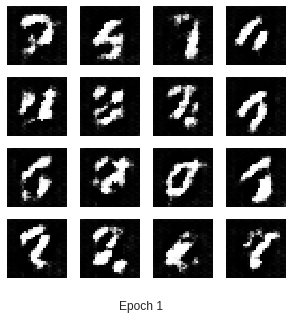

Epoch 2/30... stpes:200  Discriminator_mean loss : 0.4699... Generator_mean loss: 2.5526
Epoch 2/30... stpes:400  Discriminator_mean loss : 0.4978... Generator_mean loss: 2.4476
[2/30] - ptime: 28.23


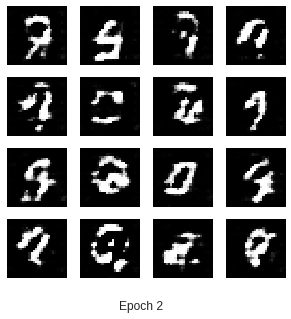

Epoch 3/30... stpes:200  Discriminator_mean loss : 0.4860... Generator_mean loss: 2.5095
Epoch 3/30... stpes:400  Discriminator_mean loss : 0.4976... Generator_mean loss: 2.4299
[3/30] - ptime: 28.21


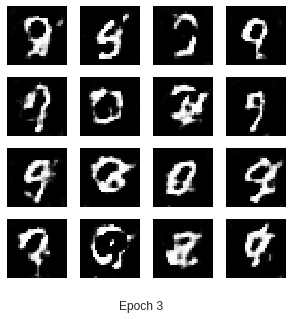

Epoch 4/30... stpes:200  Discriminator_mean loss : 0.5396... Generator_mean loss: 2.4063
Epoch 4/30... stpes:400  Discriminator_mean loss : 0.5348... Generator_mean loss: 2.3891
[4/30] - ptime: 28.21


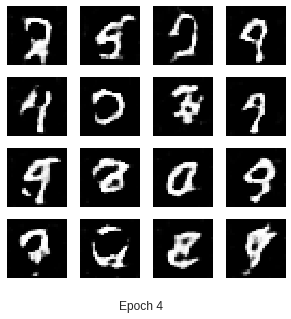

Epoch 5/30... stpes:200  Discriminator_mean loss : 0.5388... Generator_mean loss: 2.3079
Epoch 5/30... stpes:400  Discriminator_mean loss : 0.5515... Generator_mean loss: 2.2932
[5/30] - ptime: 28.23


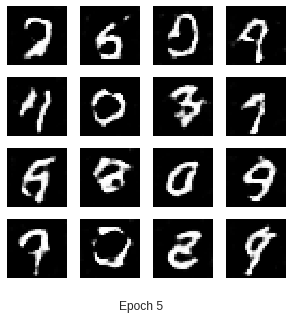

Epoch 6/30... stpes:200  Discriminator_mean loss : 0.5766... Generator_mean loss: 2.1869
Epoch 6/30... stpes:400  Discriminator_mean loss : 0.5872... Generator_mean loss: 2.1562
[6/30] - ptime: 28.22


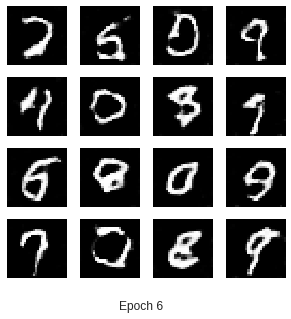

Epoch 7/30... stpes:200  Discriminator_mean loss : 0.6008... Generator_mean loss: 2.1112
Epoch 7/30... stpes:400  Discriminator_mean loss : 0.6089... Generator_mean loss: 2.0790


KeyboardInterrupt: ignored

In [0]:
import os, time, itertools, imageio, pickle, random
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
# 定义几个超参数, batch-size的大小
batch_size = 100
# 噪声的长度
noise_size = 100
# 迭代的轮数
epochs = 30
# 学习率
learning_rate = 0.0002
# 抽取样本检查生成器的性能
n_smples = 20

# 读取mnist数据集
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train = mnist.train.images, mnist.train.labels
X_train, y_train = shuffle(X_train, y_train)

# 获取生成网络和判别网络的输入
def get_input(noise_dim, image_height, image_width, image_depth):
    """
    :param noise_dim: 噪声的长度
    :param image_height: 图片的高度
    :param image_width: 图片的宽度
    :param image_depth: 图片的深度
    :return: 以placeholder形式返回两个网络的输入
    """
    D_input = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name="input_real")
    G_input = tf.placeholder(tf.float32, [None, noise_dim], name="input_noise")

    return D_input, G_input

# 定义生成器
def get_generator(G_input, output_dim, is_train=True, alpha=0.01):
    """
    :param G_input: 生成器的输入,应该是(batch_size, 100)
    :param output_dim: 生成器的输出, (batch_size, 64, 64, 1)
    :param is_train: 是否训练
    :param alpha: LeakyRelu的参数
    :return: 返回生成的图片
    """
    # 定义一个命名空间generator
    with tf.variable_scope("generator", reuse=(not is_train)):
        # batch x 100 x 1 ---> batch x 4 x 4 x 1024
        layer1 = tf.layers.dense(G_input, 7*7*128)
        layer1 = tf.reshape(layer1, [-1, 7, 7, 128])
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        #layer1 = tf.nn.dropout(layer1, rate=0.4)
        
        # batch x 8 x 8 x 512 ---> batch x 16 x 16 x 256
        #layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=1, padding="valid")
        #layer2 = tf.layers.batch_normalization(layer3, training=is_train)
        #layer2 = tf.maximum(alpha * layer3, layer3)
        #layer3 = tf.nn.dropout(layer3, rate=0.4)
        
        # batch x 16 x 16 x 256 ---> batch x 32 x 32 x 128
        layer4 = tf.layers.conv2d_transpose(layer1, 64, [3,3], strides=2, padding="same")
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(alpha * layer4, layer4)
        #layer4 = tf.nn.dropout(layer4, rate=0.4)
        
        # batch x 32 x 32 x 128 ---> batch x 64 x 64 x 1
        logits = tf.layers.conv2d_transpose(layer4, output_dim, [3,3], strides=2, padding="same")
        outputs = tf.tanh(logits)
        return outputs
# 定义一个判别器
def get_discriminator(D_input, reuse=False, alpha=0.01):
    """
    :param D_input: 输入图片
    :param reuse: 是否重用参数
    :param alpha: LeakyRelu的参数
    :return: 返回对图片的判别结果,是一个概率值
    """
    # 定义一个命名空间discriminator
    with tf.variable_scope("discriminator", reuse=reuse):
      
        # batch x 28 x 28 x 1 ---> batch x 14 x 14 x 32       
        layer1 = tf.layers.conv2d(D_input, 128, [3,3], strides=2, padding="same")
        layer1 = tf.maximum(alpha * layer1, layer1)
        #layer1 = tf.nn.dropout(layer1, rate=0.4)

        # batch x 14 x 14 x 32 ---> batch x 7 x 7 x 64
        #layer2 = tf.layers.conv2d(layer1, 64, 3, strides=2, padding="same")
        #layer2 = tf.layers.batch_normalization(layer2, training=True)
        #layer2 = tf.maximum(alpha * layer2, layer2)
        #layer2 = tf.nn.dropout(layer2, rate=0.4)

        # batch x 7 x 7 x 64 ---> batch x 4 x 4 x 128
        layer3 = tf.layers.conv2d(layer1, 64, [3,3], strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        #layer3 = tf.nn.dropout(layer3, rate=0.4)
        

        # batch x 4 x 4 x 128 ---> batch x (16*128)
        flatten = tf.reshape(layer3, (-1, 49*128))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)

        return logits, outputs

# 获取模型的损失值
def get_loss(D_input_real, G_input, image_depth, smooth=0.1):
    """
    :param D_input: 判别模型的输入
    :param G_input: 生成模型的输入
    :param image_depth: 图片的通道数,彩色为3,灰度为1
    :param smooth: 平滑值
    :return: 返回两个网络的损失
    """
    g_outputs = get_generator(G_input, image_depth, is_train=True)

    # 将真实的图片放入模型中判别
    d_logits_real, d_output_real = get_discriminator(D_input_real)

    # 将生成器生成的图片放入判别模型中判读
    d_logits_fake, d_output_fake = get_discriminator(g_outputs, reuse=True)

    #计算损失, 生成器努力让图片更加逼真
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)*(1-smooth)))

    # 判别器努力分别出真实图片和生成图片,所以判别器的损失函数是两部分
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real)*(1-smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    # 判别器的损失
    d_loss = tf.add(d_loss_fake, d_loss_real)
    # 返回损失
    return g_loss, d_loss

# 优化操作
def get_optimizer(g_loss, d_loss, learning_rate=0.001):
    """
    :param g_loss: 生成器的损失
    :param d_loss: 判别器的损失
    :param learning_rate: 学习率
    :return: 优化操作
    """
    # 分别通过tftrainable-variables()获得两个网络中的参数
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    # 返回优化操作
    return g_opt, d_opt
fixed_z_ = np.random.normal(0, 1, (16, 1, 1, 100))
def show_result(test_images,num_epoch, show = True, save = False, path = 'result.png'):
    #test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    plt.axis('off')
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
# 训练模型
def train(noise_size, data_shape, batch_size, n_samples):
    """
    :param noise_size: 噪声的维度
    :param data_shape: 图片的形状
    :param batch_size: 每个batch的大小
    :param n_samples: 抽样数目
    """
    # 计步器
    # results save folder
    root = 'MNIST_DCGAN_results/'
    model = 'MNIST_DCGAN_'
    if not os.path.isdir(root):
        os.mkdir(root)
    if not os.path.isdir(root + 'Fixed_results'):
        os.mkdir(root + 'Fixed_results')
    # 调用get_input()函数,从而获得两个网络的输入(placeholder形式)
    D_input, G_input = get_input(noise_size, data_shape[1], data_shape[2], data_shape[3])

    # 获取损失值
    g_loss, d_loss = get_loss(D_input, G_input, data_shape[-1])
    # 获取优化操作
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, learning_rate)

    # 打开一个会话
    with tf.Session() as sess:
        # 初始化所有的变量
        sess.run(tf.global_variables_initializer())
        Ephoc_D_train_losses = []
        Ephoc_G_train_losses = []
        epoch_ptime = []
        figure = 0
        np.random.seed(int(time.time()))
        start_time = time.time()
        for epoch in range(epochs):
            G_train_losses = []
            D_train_losses = []
            epoch_start_time = time.time()
            steps = 0
            for i in range(mnist.train.num_examples // batch_size):
                steps += 1
                # 获取真实图片
                batch_images=X_train[i*batch_size:(i+1)*batch_size]
                #batch_images = tf.image.resize_images(batch_images, [64, 64]).eval()
                batch_images = (batch_images - 0.5) / 0.5  # normalization; range: -1 ~ 1
                # 生成噪音
                batch_noise = np.random.normal(0, 1, size=(batch_size, noise_size))
                # 开始优化
                sess.run(d_train_opt, feed_dict={D_input: batch_images,
                                                 G_input: batch_noise})
                sess.run(g_train_opt, feed_dict={D_input: batch_images,
                                                 G_input: batch_noise})

    
                train_loss_d_ = d_loss.eval({D_input: batch_images,
                                                G_input: batch_noise})
                D_train_losses.append(train_loss_d_)
                train_loss_g_ = g_loss.eval({D_input: batch_images,
                                                G_input: batch_noise})
                G_train_losses.append(train_loss_g_)
                if steps % 200 == 0:
                   print(
                         "Epoch {}/{}... stpes:{} ".format(epoch + 1, epochs, steps),
                          "Discriminator_mean loss : {:.4f}...".format(np.mean(D_train_losses)),
                          "Generator_mean loss: {:.4f}".format(np.mean(G_train_losses))
                        )
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - epoch_start_time
            epoch_ptime.append(per_epoch_ptime)
            print('[%d/%d] - ptime: %.2f' % ((epoch + 1), epochs, per_epoch_ptime))
            fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
            temp = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
            test_images = sess.run(get_generator(temp, 1, is_train=False), feed_dict={
                                                  temp:fixed_z_})
            show_result(test_images,(epoch + 1), save=True, path=fixed_p)
            Ephoc_D_train_losses.append(np.mean(D_train_losses))
            Ephoc_G_train_losses.append(np.mean(G_train_losses))
        end_time = time.time()
        total_ptime = end_time - start_time
        print('Avg per epoch ptime: %.2f,total %d epoch, total_ptime: %.2f' % (np.mean(epoch_ptime),epochs, total_ptime))
    return Ephoc_D_train_losses,Ephoc_G_train_losses
if __name__ == '__main__':
    with tf.Graph().as_default():
        Ephoc_D_train_losses,Ephoc_G_train_losses = train(noise_size, [-1, 28, 28, 1], batch_size, n_samples=n_smples)
        x = np.linspace(1, epochs, epochs)
        fig = plt.figure()
        plt.plot(x, Ephoc_D_train_losses, '-')
        plt.plot(x, Ephoc_G_train_losses, '--')
        

In [0]:
import pickle
print(Ephoc_D_train_losses)
print(Ephoc_G_train_losses)
filename = 'Dloss.data'
f = open(filename, 'wb')
pickle.dump(Ephoc_D_train_losses,f)
f.close()
filename = 'Gloss.data'
f = open(filename, 'wb')
pickle.dump(Ephoc_G_train_losses,f)
f.close()
from google.colab import files
files.download('Dloss.data')
files.download('Gloss.data')

[0.41369697, 0.4682778, 0.5011553, 0.5349004, 0.5703436, 0.5893567, 0.59478337, 0.60365206, 0.5997238, 0.5906946, 0.58748525, 0.58898443, 0.5649967, 0.552834, 0.55900884, 0.53383356, 0.5396522, 0.54764193, 0.52153605, 0.5280653, 0.53829944, 0.5569189, 0.5421539, 0.53722733, 0.53606063, 0.5294124, 0.53452945, 0.5548111, 0.5437027, 0.54035]
[3.5328486, 2.7474391, 2.6158252, 2.564536, 2.3478076, 2.2115943, 2.3083825, 2.195449, 2.2147975, 2.2681348, 2.2913828, 2.258724, 2.3585277, 2.3883393, 2.410537, 2.4829962, 2.4919825, 2.485399, 2.5734966, 2.5605, 2.550057, 2.524154, 2.5503585, 2.5646622, 2.5672834, 2.5662732, 2.574683, 2.5724232, 2.5480142, 2.5772114]


In [0]:
type(Ephoc_D_train_losses)

list